### Raster Data to Explore
    Landscan
    Worldpop
    NTL - DMSP & VIIRS
    Africapolic 
    EU Human Settlement Layer
    MODIS built layer
    Facebook Human Settlement
    GRUMP
    
### Define Urban Density
    Go w/ former US Census threshold of >= 1000 ppl per sq mile
    https://www2.census.gov/geo/pdfs/reference/GARM/Ch12GARM.pdf

In [2]:
import os
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from rasterio.mask import mask
import geopandas as gpd
import fiona
import rasterio
import rasterio.mask
import numpy as np
import skimage.io as skio

In [3]:
cwd = os.getcwd()
cwd

'/tana-spin/cascade/projects/NightTimeLights/notebooks/jupyter'

In [25]:
Infilepath = "/home/cascade/tana-spin-cascade/projects/NightTimeLights/data/raw/" # will build out folders later
OutFilePath = 

In [26]:
africa1k_2000 = rasterio.open(filepath+"AFR_PPP_2000_adj_v2.tif")
africa1k_2000.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11161,
 'nodata': -3.4028234663852886e+38,
 'transform': Affine(0.00833333329999305, 0.0, -33.3254172868223,
       0.0, -0.00833333329999305, 41.791250202105076),
 'width': 12575}

In [27]:
test = africa1k_2000.read(1)

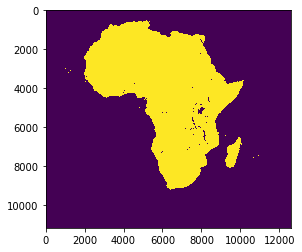

In [28]:
plot.show(test)

In [29]:
len(np.unique(test))

2765743

In [31]:
# https://www2.census.gov/geo/pdfs/reference/ua/Defining_Rural.pdf

density = 1000/ 2.59 #density per sq km from sq mi
print(density)

386.1003861003861


In [35]:
from skimage import measure
label_test = measure.label(subset_copy, background=0, return_num=True)
label_test_arr = label_test[0]
label_test_num = label_test[1] # 96 polygons

In [36]:
label_test_num

96

/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/opt/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


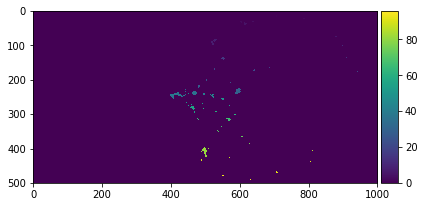

In [37]:
skio.imshow(label_test_arr)

In [38]:
# build mask for all of Africa for 2000
# subset_copy = copy.copy(africa1k_2000.read(1))
# subset_copy[subset_copy < density] = 0
# subset_copy[subset_copy >= density] = 1

In [39]:
# label_test = measure.label(subset_copy, background=0, return_num=True)
# label_test_arr = label_test[0]
# label_test_num = label_test[1] # 38377 polygons

In [40]:
# print(africa1k_2000.shape)
# print(label_test_num)how

In [41]:
# plot.show(label_test_arr)

### Now we need to write the mask back out as a geotiff
http://www.loicdutrieux.net/pyLandsat/NDVI_calc.html

In [42]:
# Define spatial characteristics of output object 
# (basically they are analog to the input)
# kwargs = africa1k_2000.meta

# Update kwargs (change in data type)
# kwargs.update(
#    dtype=rasterio.float32,
#    count = 1)

# Let's see what is in there
# print(kwargs)

# with rasterio.open('africa1k_2000_mask.tif', 'w', **kwargs) as dst:
#        dst.write_band(1, label_test_arr.astype(rasterio.float32))

In [43]:
# see if the file works 
# mask_test = rasterio.open("africa1k_2000_mask.tif")
# mask_test.meta

In [44]:
#plot.show(mask_test.read(1))

In [45]:
# np.unique(mask_test.read(1))

[0. 1.]


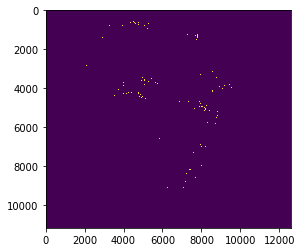

In [46]:
# Let's try to make the mask directy with rasterio

new_mask = africa1k_2000.read(1)
new_mask[new_mask < 386.10] = 0
new_mask[new_mask > 386.10] = 1
print(np.unique(new_mask))
plot.show(new_mask)


In [47]:
# Define spatial characteristics of output object 
# (basically they are analog to the input)
kwargs = africa1k_2000.meta

# Update kwargs (change in data type)
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Let's see what is in there
print(kwargs)

with rasterio.open(filepath+'africa1k_2000_mask.tif', 'w', **kwargs) as dst:
        dst.write_band(1, new_mask.astype(rasterio.float32))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 12575, 'height': 11161, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.00833333329999305, 0.0, -33.3254172868223,
       0.0, -0.00833333329999305, 41.791250202105076)}


In [48]:
# open the threshold mask as a rasterio object and see what's in it
mask_test = rasterio.open(filepath+"africa1k_2000_mask.tif")
mask_test.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11161,
 'nodata': -3.4028234663852886e+38,
 'transform': Affine(0.00833333329999305, 0.0, -33.3254172868223,
       0.0, -0.00833333329999305, 41.791250202105076),
 'width': 12575}

In [49]:
np.unique(mask_test.read(1)) 

array([0., 1.], dtype=float32)

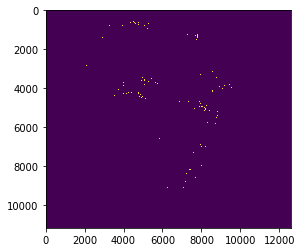

In [50]:
plot.show(mask_test.read(1))

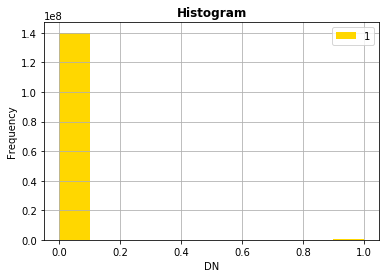

In [51]:
#plot.show_hist(mask_test.read(1))

### Next we need to open the mask and turn it into polygons
### Then we need to load the points and do an in/out search in geo pandas
### Then we need to make a new mask with the polygons that contain the points
### Last (we hope) we need to apply that mask to the Africa 2000 geotif and convert the final into a shape file that retains the values for the polygons
### But really last, then we need to sum up the population values for each polygon and return it as a list
### Cannot forget that at some point we need to attach the name labels from the points to the polygons, as well as countries ... I think we can come back and do this later

In [52]:
# This is a sanity check that the shapes method does something 

# import pprint

# from rasterio.features import shapes

# with rasterio.open(filepath+'africa1k_2000_mask.tif') as src:
#     image = src.read(1)
    
#     pprint.pprint(list(shapes(image))[:2])

### BELOW THIS IS AN ATTEMPT TO MAKE A POLYGONE SHAPE FILE

In [53]:
from rasterio import features as features

# with rasterio.open(filepath+'africa1k_2000_mask.tif', 'r', **kwargs) as dst:
#         africa1k_2000_poly = features.shapes(dst, mask= africa1k_2000_poly.read(1))
#         print(type(africa1k_2000_poly))
#         geoms = list(africa1k_2000_poly)

with rasterio.open(filepath+'africa1k_2000_mask.tif') as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.read(1)

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
#        print(geom)

In [54]:
type(geom)

dict

In [55]:
# check length 
len(geom["coordinates"])

39423

In [56]:
import pandas as pd
import shapely.geometry import Polygon

# turn dict into normal data frame
test_kelly = pd.DataFrame.from_dict(geom).apply(Polygon)
test.head(8)

SyntaxError: invalid syntax (<ipython-input-56-355d146d8973>, line 2)

In [ ]:
# use shapely to turn those cols into individual polygon objects 

#test['geometry'] = test['coordinates'].apply(Polygon)
#test.head(6)

In [ ]:
# move into a geo pandas data frame and assign it some geometry

new_pdf = gp.GeoDataFrame(test, geometry = 'geometry')
new_pdf.head(6)

In [ ]:
# isolate just the geometry Polygon column 

newer_pdf = gp.GeoDataFrame(new_pdf['geometry'])
newer_pdf.head(6)

### The cell below this works ... makes a shapefile 

In [ ]:
# Explort it as a shape file
# careful with the file path ... this is going to my notebooks folder right now
newer_pdf.to_file('worldpop_2000_test.shp', driver='ESRI Shapefile')

In [ ]:
# Let's see if I can find zonal stats

In [ ]:
# https://automating-gis-processes.github.io/CSC18/lessons/L6/zonal-statistics.html

from rasterstats import zonal_stats

In [ ]:
# Need to figure out how to turn geo pandas back into a geojson dict
with fiona.open("worldpop_2000_test.shp", "r") as shapefile:                                #<--- Need to figure out how to get the geometry from shp file directly 
    features = [feature["geometry"] for feature in shapefile]

with rasterio.open(filepath+"AFR_PPP_2000_adj_v2.tif") as src:                        #<--- Need to figure out how to get it not to write to a file, but just store in memory at this point
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(filepath+"AFR_PPP_2000_adj_MASK.tif", "w", **out_meta) as dest:
    dest.write(out_image) 


In [ ]:
mask_test_2000 = rasterio.open(filepath+'AFR_PPP_2000_adj_MASK.tif')
plot.show(mask_test_2000)

In [ ]:
np.unique(mask_test_2000.read(1))

In [ ]:
# from shapely.geometry import shape

# test = shape(geom)
# type(test)

In [ ]:
# get it into a geopandas DF for explore
import geopandas as gp
geom_gdf = gp.GeoDataFrame.from_records(geom)
type(geom_gdf)

In [ ]:
# check it 
geom_gdf.head(2)

In [ ]:
geom_gdf[type=='Polygon'] = 'POLYGON '
geom_gdf.head(2)

In [ ]:
geom_gdf['geometry']=geom_gdf['False'].astype(str)+geom_gdf['coordinates'].astype(str)

In [ ]:
geom_gdf.head(6)

In [ ]:
test = gp.GeoDataFrame(geom_gdf['geometry'])
test.head(6)

In [ ]:
# try to write it as a shape file
test.to_file('worldpop_2000_test.shp', driver='ESRI Shapefile')

In [ ]:
type(dst)

In [ ]:
dir(africa1k_2000_poly)

In [ ]:
test = rasterio.features.dataset_features(africa1k_2000_poly)







In [ ]:
type(test)

In [ ]:
# ask Kelly about what to do with the nodata values messing everything up 
ghana100m_2010 = rasterio.open(filepath+"GHA10_040213.tif")
ghana100m_2010.meta

In [ ]:
plot.show(ghana100m_2010)

In [ ]:
ghana100m_2010_arr = ghana100m_2010.read_band(1)

In [ ]:
# check data range
np.unique(ghana100m_2010_arr)

In [ ]:
# Zoom into a subset
#window = rasterio.windows.Window(1024, 1024, 1280, 2560)

subset = ghana100m_2010.read(1, window=((7000, 7200), (2700, 3300)))

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
#plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [ ]:
type(subset)

In [ ]:
plt.hist(subset, range = [0,100])
plt.show()

In [ ]:
import copy

subset_copy = copy.copy(subset)
subset_copy[subset<1] = 0

In [ ]:
plt.figure(figsize=(6,8.5))
plt.imshow(subset_copy)
plt.colorbar(shrink=0.5)
plt.xlabel('Column #')
plt.ylabel('Row #')

In [ ]:
plt.hist(subset_copy)
plt.show()

In [ ]:
test = rasterio.open(filepath+"GHA10_040213.tif")

In [ ]:
test.mask

In [ ]:
type(test_band)

In [ ]:
from rasterio.features import shapes
mask = None
with rasterio.drivers():
    with rasterio.open(filepath+"GHA10_040213.tif", window = ((7000, 7200), (2700, 3300))) as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.affine)))

In [ ]:
geoms = list(results)

In [ ]:
print(geoms[4])

In [ ]:
import geopandas as gp
gpd_polygonized_raster  = gp.GeoDataFrame.from_features(geoms)

In [ ]:
gpd_polygonized_raster